# Holy Quran Sentiment Analysis

Problem Statement:
A sentiment analysis job of the "Holy Quran" to first classify positive, negative, and neutral verses, followed by categorizing specific frequent words. 

Disclaimer:
The "holyquran.csv" file has been prepared and used which is the verbatim translation of the Islamic scholar Farid Ul Haq and endorsed by Sahee International. This is an educational attempt to utilize AI tools for analysis and the AI Practitioner has not manipulated the data in any manner. 

In [1]:
#Basic libraries for NLP and data processing
import numpy as np
import pandas as pd
import re, string, unicodedata
import nltk
import spacy
from sklearn import preprocessing

#Special libraries for NLP
nltk.download('punkt')
from nltk import pos_tag
from bs4 import BeautifulSoup                 # Beautiful soup is a parsing library that can use different parsers.
from nltk import word_tokenize, sent_tokenize # Tokenization libraries
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords, wordnet    # Stopwords, and wordnet corpus
stopWords = set(stopwords.words('english'))
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer  # Stemmer & Lemmatizer librarties

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

import gensim
!pip install contractions
import contractions

!pip install vaderSentiment

#Specific libraries for data visualization
from wordcloud import WordCloud
from grid import * 
from collections import Counter
import plotly
from plotly import graph_objs
from time import time
plotly.offline.init_notebook_mode()
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

#Specific libraries for model builduing and analysis
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from itertools import cycle
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

np.random.seed(101)

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


Using TensorFlow backend.


# Loading Data & EDA

In [54]:
verse = pd.read_csv('holyquran.csv', encoding='cp1252')

len(verse)

6197

In [55]:
verse.columns

Index(['Surah ID', 'Verse ID', 'Ayah Text'], dtype='object')

In [56]:
verse['Ayah Text'].describe()

count                                                  6197
unique                                                 6093
top       "So O men and jinns! Which favour of your Lord...
freq                                                     31
Name: Ayah Text, dtype: object

In [133]:
verse.head()

verse_sentiment                                          Ayah Text
0                1  "All praise is to Allah the Lord Of The Creati...
1                1              "The Most Gracious the Most Merciful"
2                1                   "Owner of the Day of Recompense"
3                1  "You alone we worship and from You alone we se...
4                1                   "Guide us on the Straight Path."

In [134]:
verse['Ayah Text'][108]

'"And they followed what the devils used to read during the rule of Sulaiman (Solomon - peace and blessings be upon him); and Sulaiman did not disbelieve but the devils disbelieved - they teach people magic; and that which was sent down to the two angels Harut and Marut in Babylon; and the two (angels) never taught a thing to anyone until they used to say “We are only a trial therefore do not lose your faith” and they used to learn from them that by which they cause division between man and his wife; and they cannot harm anyone by it except by Allah’s command; and they learn what will harm them not benefit them; and surely they know that whoever bargains for this will not have a share in the Hereafter; and for what an abject thing they have sold themselves; if only they knew!"'

# Text Pre-processing

In [135]:
#Tokenization

tokenized_verse = verse['Ayah Text'].apply(lambda x: x.split())
tokenized_verse.head()

0    ["All, praise, is, to, Allah, the, Lord, Of, T...
1         ["The, Most, Gracious, the, Most, Merciful"]
2              ["Owner, of, the, Day, of, Recompense"]
3    ["You, alone, we, worship, and, from, You, alo...
4              ["Guide, us, on, the, Straight, Path."]
Name: Ayah Text, dtype: object

In [136]:
from nltk.corpus import stopwords
print (stopwords.words("english")) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [137]:
words = verse['Ayah Text']

In [138]:
words = [w for w in words if not w in stopwords.words("english")]
print (words)

['"All praise is to Allah the Lord Of The Creation."', '"The Most Gracious the Most Merciful"', '"Owner of the Day of Recompense"', '"You alone we worship and from You alone we seek help (and may we always)."', '"Guide us on the Straight Path."', '"The path of those whom You have favoured -"', '"Not the path of those who earned Your anger - nor of those who are astray. "', '"Alif-Laam-Meem. (Alphabets of the Arabic language; Allah and to whomever He reveals know their precise meanings.)"', '"This is the exalted Book (the Qur’an) in which there is no place for doubt; a guidance for the pious."', '"Those who believe without seeing (the hidden) and keep the (obligatory) prayer established and spend in Our cause from what We have bestowed upon them."', '"And who believe in this (Qur’an) which has been sent down upon you O beloved Prophet (Mohammed - peace and blessings be upon him) and what was sent down before you; and are certain of the Hereafter."', '"It is they who are on guidance from

In [139]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [140]:
clean_review = review_to_words( verse["Ayah Text"][369] )
print (clean_review)

accept abject prices exchange allah covenant oaths portion hereafter allah neither speak look towards day resurrection purify painful punishment


In [141]:
# Get the number of reviews based on the dataframe column size

num_reviews = verse["Ayah Text"].size

# Initialize an empty list to hold the clean reviews
clean_train_verse = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in range( 0, num_reviews ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_verse.append( review_to_words( verse["Ayah Text"][i] ) )

In [142]:
clean_train_verse[666]

'mankind indeed clear proof lord come sent bright light holy prophet clear proof allah'

In [78]:
clean_train_verse[786]

'punish indeed slaves forgive indeed almighty wise'

# WordCloud

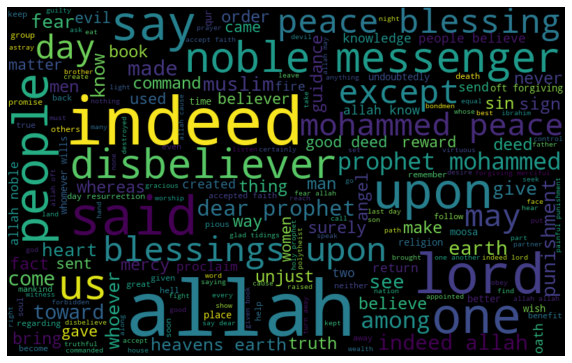

In [79]:
all_words = ' '.join([text for text in clean_train_verse])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Vectorization

In [80]:
#Bag Of Words

bow_vector = CountVectorizer(max_df=0.90, min_df=2, max_features=5000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vector.fit_transform(clean_train_verse)
bow = bow.toarray()
print(bow)
print(bow.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(6197, 3332)


In [105]:
#TF-IDF

tfidf_vector = TfidfVectorizer(max_df=0.90, min_df=2, max_features=5000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vector.fit_transform(clean_train_verse)

print(tfidf)
print(tfidf.shape)

  (0, 616)	0.597556075287842
  (0, 1752)	0.3414748921323259
  (0, 105)	0.24696444047822597
  (0, 2172)	0.682151156320272
  (1, 1831)	0.6546539435768487
  (1, 1275)	0.7559287097069937
  (2, 2352)	0.6006839010519786
  (2, 663)	0.3550274729698162
  (2, 2033)	0.7163339615386409
  (3, 1400)	0.6240444983215453
  (3, 2609)	0.5845971190100442
  (3, 3290)	0.5184734058365648
  (4, 2073)	0.5244289139492997
  (4, 2842)	0.614139367202992
  (4, 1321)	0.5897517713966333
  (5, 1091)	0.8429234396616623
  (5, 2073)	0.5380335257852914
  (6, 206)	0.41966083017266564
  (6, 128)	0.6131232106848881
  (6, 893)	0.533310530338738
  (6, 2073)	0.4044064717188112
  (7, 1815)	0.30116389076140987
  (7, 2186)	0.3028243400320238
  (7, 1649)	0.194040031893377
  (7, 2475)	0.30116389076140987
  :	:
  (6191, 671)	0.31644209539967544
  (6191, 2215)	0.3578389849464834
  (6191, 1795)	0.40178442624279936
  (6191, 334)	0.2964895559911055
  (6191, 2082)	0.28541912863076985
  (6191, 1877)	0.30405138338340304
  (6191, 2236)	0.280

# Model Building: Sentiment Analysis

#Model building using Bag of Words

In [83]:
 from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    #note: depending on how you installed (e.g., using source code download versus pip install), you may need to import like this:
    #from vaderSentiment import SentimentIntensityAnalyzer

# --- examples -------
sentences = []

sia = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

In [89]:
verse['scores'] = verse['Ayah Text'].apply(lambda review: sia.polarity_scores(review))

verse.head()

Surah ID  Verse ID                                          Ayah Text  \
0         1         1  "All praise is to Allah the Lord Of The Creati...   
1         1         2              "The Most Gracious the Most Merciful"   
2         1         3                   "Owner of the Day of Recompense"   
3         1         4  "You alone we worship and from You alone we se...   
4         1         5                   "Guide us on the Straight Path."   

                                              scores  
0  {'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'comp...  
1  {'neg': 0.0, 'neu': 0.562, 'pos': 0.438, 'comp...  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
3  {'neg': 0.201, 'neu': 0.553, 'pos': 0.246, 'co...  
4  {'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...

In [90]:
verse['compound']  = verse['scores'].apply(lambda score_dict: score_dict['compound'])

verse.head()

Surah ID  Verse ID                                          Ayah Text  \
0         1         1  "All praise is to Allah the Lord Of The Creati...   
1         1         2              "The Most Gracious the Most Merciful"   
2         1         3                   "Owner of the Day of Recompense"   
3         1         4  "You alone we worship and from You alone we se...   
4         1         5                   "Guide us on the Straight Path."   

                                              scores  compound  
0  {'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'comp...    0.6908  
1  {'neg': 0.0, 'neu': 0.562, 'pos': 0.438, 'comp...    0.5984  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000  
3  {'neg': 0.201, 'neu': 0.553, 'pos': 0.246, 'co...    0.2263  
4  {'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...    0.2263

In [91]:
verse['comp_score'] = verse['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

verse.head()

Surah ID  Verse ID                                          Ayah Text  \
0         1         1  "All praise is to Allah the Lord Of The Creati...   
1         1         2              "The Most Gracious the Most Merciful"   
2         1         3                   "Owner of the Day of Recompense"   
3         1         4  "You alone we worship and from You alone we se...   
4         1         5                   "Guide us on the Straight Path."   

                                              scores  compound comp_score  
0  {'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'comp...    0.6908        pos  
1  {'neg': 0.0, 'neu': 0.562, 'pos': 0.438, 'comp...    0.5984        pos  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000        pos  
3  {'neg': 0.201, 'neu': 0.553, 'pos': 0.246, 'co...    0.2263        pos  
4  {'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...    0.2263        pos

In [93]:
#Label encoding of target categorical column where 0 = negative, 1 = neutral, 2 = positive

label_encoder = preprocessing.LabelEncoder()
verse['verse_sentiment']= label_encoder.fit_transform(verse['comp_score']) 
verse.head()

Surah ID  Verse ID                                          Ayah Text  \
0         1         1  "All praise is to Allah the Lord Of The Creati...   
1         1         2              "The Most Gracious the Most Merciful"   
2         1         3                   "Owner of the Day of Recompense"   
3         1         4  "You alone we worship and from You alone we se...   
4         1         5                   "Guide us on the Straight Path."   

                                              scores  compound comp_score  \
0  {'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'comp...    0.6908        pos   
1  {'neg': 0.0, 'neu': 0.562, 'pos': 0.438, 'comp...    0.5984        pos   
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000        pos   
3  {'neg': 0.201, 'neu': 0.553, 'pos': 0.246, 'co...    0.2263        pos   
4  {'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...    0.2263        pos   

   verse_sentiment  
0                1  
1                1  
2                1  
3                1  
4                1

In [94]:
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, verse['verse_sentiment'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [95]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int, average='micro') # calculating f1 score

0.7924731182795699

#Model building using TF-IDF

In [96]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [97]:
lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int, average='micro')

0.7419354838709677

# Visualization

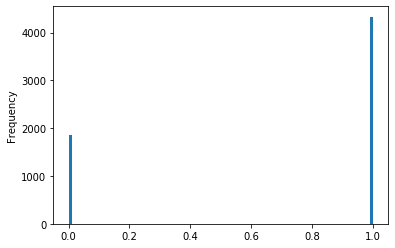

In [98]:
verse['verse_sentiment'].plot(kind='hist', bins=100)

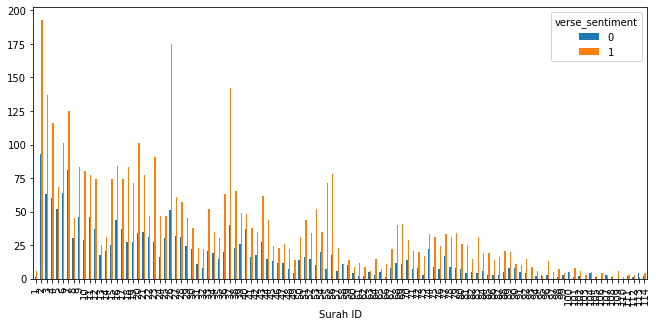

In [99]:
verse.groupby(['Surah ID', 'verse_sentiment']).size().unstack().plot(kind='bar',figsize=(11, 5))

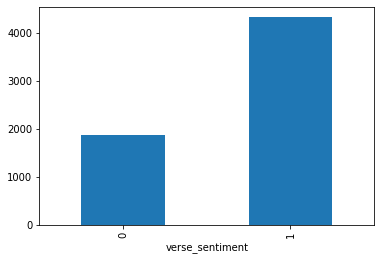

In [101]:
verse.groupby('verse_sentiment').size().plot(kind='bar')

In [172]:
import re
import string
frequency = {}
document_text = open('holyquran.csv', 'r')
text_string = document_text.read().lower()
match_pattern = re.findall(r'\b[a-z]{3,15}\b', text_string)
 
for word in match_pattern:
    count = frequency.get(word,0)
    frequency[word] = count + 1
     
frequency_list = frequency.keys()
 
for words in frequency_list:
    print (words, frequency[words])

surah 3
verse 13
ayah 1
text 6
all 986
praise 47
allah 2942
the 9426
lord 967
creation 95
most 433
gracious 58
merciful 123
owner 14
day 555
recompense 47
you 4352
alone 17
worship 197
and 9610
from 1341
seek 102
help 79
may 490
always 12
guide 64
straight 49
path 123
those 943
whom 229
have 1235
favoured 6
not 2092
who 1779
earned 24
your 1269
anger 8
nor 296
are 1452
astray 103
alif 13
laam 4
meem 17
alphabets 25
arabic 37
language 37
whomever 156
reveals 28
know 292
their 1379
precise 27
meanings 29
this 967
exalted 5
book 238
qur 136
which 576
there 273
place 109
for 1887
doubt 56
guidance 140
pious 83
believe 279
without 58
seeing 47
hidden 91
keep 113
obligatory 29
prayer 105
established 64
spend 50
our 494
cause 128
what 915
bestowed 85
upon 1054
them 2284
has 735
been 202
sent 395
down 309
beloved 14
prophet 461
mohammed 312
peace 406
blessings 350
him 1419
was 298
before 348
certain 20
hereafter 113
they 2736
successful 20
whose 90
fate 28
disbelief 50
whether 37
warn 40
one 6

dispute 23
more 109
prevents 1
name 35
being 77
mentioned 19
mosques 8
strives 4
ruin 51
befit 19
east 10
west 9
belong 14
whichever 4
direction 6
entity 4
directed 8
capable 12
powers 1
reach 51
limitless 3
offspring 19
himself 58
dominion 1
submissive 3
originator 3
happens 9
sign 80
also 45
spoken 10
way 134
alike 5
giving 26
conveying 2
questioned 19
pleased 28
follow 83
religion 93
true 104
followers 22
desires 41
aide 6
manner 21
superior 3
ibrahim 86
abraham 4
tested 13
matters 45
fulfilled 9
going 14
appoint 26
leader 9
invoked 3
include 3
doers 1
house 28
mecca 12
recourse 1
sanctuary 1
stood 7
imposed 2
duty 14
ismail 10
ishmael 3
purify 7
prayed 21
security 2
bestow 40
various 12
providence 1
disbelieves 10
provide 29
subsistence 1
compel 1
wretched 36
raising 4
foundations 2
along 69
obedient 10
show 56
ways 14
incline 28
instruct 3
sound 11
wisdom 30
almighty 51
traditions 6
sunnah 2
hadith 3
called 36
renounce 1
fool 2
chose 15
worthy 20
closest 4
submit 22
submitted 29
y

intention 6
deal 12
dislike 9
placed 23
slander 8
unveiled 2
wedded 3
grand 3
already 24
shame 8
foster 3
fed 3
cohabited 4
grandsons 2
keeping 5
wedlock 1
appointment 2
masters 3
becoming 3
faithful 4
prescribed 3
falling 9
explain 20
pleasures 1
separated 7
lessen 1
oppression 4
easy 28
avoiding 4
cardinal 4
dues 1
guarding 3
decreed 23
advise 13
lastly 1
beat 1
arbitrator 2
conciliation 1
unite 3
related 7
neighbour 2
unrelated 1
companion 17
boastful 5
misers 1
miserliness 4
doubles 1
watcher 1
buried 5
ground 10
levelled 1
intoxicated 2
bathed 1
travelling 4
ill 17
returns 6
answering 2
nature 2
stroke 2
purchase 1
interchange 1
distorting 1
transform 2
carried 6
lower 4
ascribes 4
invented 5
cleanliness 1
hair 5
date 14
seed 5
manifest 8
idols 21
rightly 9
sesame 2
skins 8
cooked 1
burnt 1
plentiful 1
shade 9
owners 7
refer 2
outcome 17
wishes 13
mislead 14
told 15
swearing 2
goal 4
harmony 4
obeyed 11
souls 21
intercedes 1
oath 89
opposition 4
wholeheartedly 3
families 5
advised

decision 13
shoaib 3
lived 3
humble 6
prosperity 1
numerous 5
comfort 7
unafraid 6
inherited 3
seals 4
relate 11
respective 3
sets 8
court 11
members 14
python 1
putting 1
withdrew 1
shone 2
chieftains 6
expert 5
magician 13
announcers 1
magicians 14
throw 12
spell 8
terrified 3
swallowing 2
disproved 1
defeated 4
humiliated 6
plotted 3
releasing 1
appoints 2
successor 2
final 10
triumph 2
rulers 2
famine 1
reduction 2
omens 2
luck 3
flood 3
locusts 2
vermin 1
insects 1
frogs 1
lift 6
consequently 3
lifted 3
revenge 17
ignoring 1
inheritors 9
eastern 1
western 2
built 8
contrived 1
transported 3
across 3
squat 3
condition 9
destruction 5
afflicting 2
thirty 2
solitude 1
adding 1
amounted 1
deputy 2
allow 2
mountain 6
blew 3
bits 8
unconscious 2
regaining 1
consciousness 1
bestowing 1
wrote 2
tablets 3
details 2
admired 1
tread 7
pretended 1
moulded 4
ornaments 8
lifeless 2
body 8
sounds 2
speaks 8
realised 4
angry 4
upset 2
handled 1
stone 8
catching 1
pulling 1
probably 2
laugh 13
ide

preventing 4
perish 2
sustain 1
replace 4
foreign 3
cloak 1
starvation 1
unwittingly 1
detached 2
planning 2
aqsa 3
beholder 3
refers 1
physical 1
beyond 4
boarded 5
militant 1
reversed 1
second 2
maim 1
repeat 2
calculation 2
accounting 1
distinctively 1
attached 1
register 3
ledger 1
generation 8
fleeting 4
condemned 2
pushed 3
accordingly 1
believer 7
constraint 2
helpless 3
uff 2
rebuff 1
disgust 3
wing 2
nursed 1
expecting 1
assistance 1
reproached 2
beholds 2
correctly 2
haughtily 2
thrown 8
rebuked 2
rebuffed 2
profound 2
proclamation 1
invisible 1
flee 11
discuss 1
decomposed 2
iron 5
deem 2
praising 11
sows 1
constrained 1
spectacle 5
try 1
ascent 3
zakkum 1
inhabitants 5
behold 3
honoured 9
crush 4
voice 6
cavalry 1
infantry 1
sails 2
suppressed 1
somewhat 1
frighten 1
oust 1
rules 3
changing 4
declining 1
reading 3
helpful 1
arrived 1
vanished 3
vanish 1
arrival 2
touches 1
pattern 1
advocate 1
equivalent 1
spring 10
gushing 2
peacefully 2
inflame 1
miser 2
nine 6
openers 1


workers 1
zaqqum 3
sprouts 1
demons 3
ranking 4
shot 1
glance 3
pagans 2
transmit 1
sneaked 1
striking 4
sculpted 1
furnace 1
commanding 1
meritorious 1
working 1
downwards 1
commemorated 1
zil 1
ilyas 2
baal 1
idol 1
drawn 1
swallowed 1
blamed 1
ashore 1
gourd 1
courtyards 1
renowned 1
alphabet 2
cling 1
steadfastly 1
objective 1
christianity 1
latest 1
newly 1
inevitable 1
scaled 1
ninety 1
ewes 2
ewe 2
demands 1
add 1
footed 1
steeds 1
cherish 1
caressing 1
builders 1
divers 1
bathing 1
broom 1
genuine 1
pillows 1
heavenly 3
fabricator 1
regarded 1
apply 1
envelops 2
triple 1
grants 1
revel 1
chambers 3
dries 1
fragments 2
consistent 1
throughout 1
paired 2
hairs 1
shield 3
belonging 1
threaten 1
attains 1
demise 1
reflect 2
types 1
constricted 1
imagined 2
failures 1
compress 1
rolled 2
shine 2
mounts 1
delivered 3
rewarding 1
abhorrence 1
confess 1
nothingness 1
instils 3
impending 2
covert 1
renders 1
transgressor 4
outcry 1
doubtful 4
disgusting 1
routes 2
evident 4
entrust 1
cr

In [177]:
file = open('holyquran.csv', 'r')
book = file.read()


def tokenize():
    if book is not None:
        words = book.lower().split()
        return words
    else:
        return None
        

def map_book(tokens):
    hash_map = {}

    if tokens is not None:
        for element in tokens:
            # Remove Punctuation
            word = element.replace(",","")
            word = word.replace(".","")

            # Word Exist?
            if word in hash_map:
                hash_map[word] = hash_map[word] + 1
            else:
                hash_map[word] = 1

        return hash_map
    else:
        return None


# Tokenize the Book
words = tokenize()
word_list = ['allah', 'prophet', 'kill','slave','black','white','hell', 'heaven', 'punish', 'punishment', 'sinners', 'sins', 'disbelievers', 'disbeliever', 'transgressors', 'fight', 'satan']

# Create a Hash Map (Dictionary)
map = map_book(words)

# Show Word Information
for word in word_list:
    print('Word: [' + word + '] Frequency: ' + str(map[word]))

Word: [allah] Frequency: 2171
Word: [prophet] Frequency: 382
Word: [kill] Frequency: 30
Word: [slave] Frequency: 9
Word: [black] Frequency: 6
Word: [white] Frequency: 6
Word: [hell] Frequency: 71
Word: [heaven] Frequency: 35
Word: [punish] Frequency: 39
Word: [punishment] Frequency: 272
Word: [sinners] Frequency: 3
Word: [sins] Frequency: 48
Word: [disbelievers] Frequency: 258
Word: [disbeliever] Frequency: 9
Word: [transgressors] Frequency: 2
Word: [fight] Frequency: 58
Word: [satan] Frequency: 29


# Summary

1. There is not a single verse with positive sentiment in the entire book (compound sentiment >1.45 considered).
2. Regarding frequency of specific words, negative ones have a higher weightage than positive ones. 

#Close Out Dead End 